In [1]:
## Imports ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable

import gym
import numpy as np
from itertools import count

import logger 

import pdb 

/home/aashi/penv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Environment Declaration ##
env = gym.make('CartPole-v0')
env.seed(0)
torch.manual_seed(0)
gamma = 0.99 
eps = np.finfo(np.float32).eps.item() 
## for removing numerical instability
global_step = 0 
tb_folder = './sample_efficiency'
tb = logger.Logger(tb_folder, name='freeloc') 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
## Policy Network ## 
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 8)
        self.affine2 = nn.Linear(8, 2)
        
        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

In [4]:
## Select action based on policy network ## 
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    state = Variable(state)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    
    arr = action.data.numpy() ## Variable to numpy array
    return arr[0]

In [5]:
## Update policy network after recording one episode ##
def train_policy_network_after_one_episode():
    R = 0 
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]:
        R = r + gamma*R 
        rewards.insert(0, R)

    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean())/(rewards.std() + eps)
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob*reward)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [6]:
## trainPolicy for gievn number of episodes either on real episodes or fake episodes ##
def trainPolicy(numEpisodes, real=True):
    global global_step
    for i in range(0, numEpisodes):
        
        if (real):
            state = env.reset()
#             real_episodes += 1 
        else:
            state = np.random.uniform(-0.1,0.1,[4])
        done = False
        t = 0 

        while (not done and t < 200):
            action = select_action(state)
            t += 1
            if (real):
                xs.append(state)
                action_seq.append(action)
                state, reward, done, _ = env.step(action)
                next_xs.append(state)
                rs.append(reward)
                ds.append(done)
            else:
                next_state_p, reward, done = stepModel(state, action)
                state = next_state_p.data.numpy()
                state = state[0]
                reward = reward.data.numpy()[0][0]
                done = done.data.numpy()[0][0]
                done = (done > 0.1)
            policy.rewards.append(reward)
        
        train_policy_network_after_one_episode()
        if (real):
            global_step += 1
            if (global_step % 10 == 0):
                total_reward = test(20)
                tb.scalar_summary('Episode Reward', total_reward, global_step)
    print('Episode {}\t Length of episode {:5d}'.format(i, t))

In [7]:
### Network to learn model dynamics ### 
class Model(nn.Module):
    def __init__(self, batch_size = 1):
        super(Model, self).__init__()
        self.nh = 256
        self.last_layer = nn.Sequential(nn.Linear(5, self.nh),
                                nn.ReLU(), 
                                nn.Linear(self.nh, self.nh),
                                nn.ReLU())
        
        self.next_state = nn.Sequential(nn.Linear(self.nh, 4))
        self.reward = nn.Sequential(nn.Linear(self.nh, 1))
        self.done = nn.Sequential(nn.Linear(self.nh, 1), nn.Sigmoid())
        self._loss = None
        self.batch_size = batch_size
        self.L2loss = nn.MSELoss()
        self.terminalLoss = nn.BCELoss() 
        
    @property
    def loss(self):
        return self._loss 
        
    def forward(self, data, targets):
        
        ## data would be (state, action)
        data = data.view(self.batch_size, 5)
        f = self.last_layer(Variable(data))
        next_state_p = self.next_state(f)
        reward_p = self.reward(f)
        done_p = self.done(f)
        self._loss = self.build_loss(next_state_p, reward_p, done_p, targets) 
        return next_state_p, reward_p, done_p

    def forward_test(self, data):
        
        ## data would be (state, action)
        ## at test time, it has to be one input
        data = data.view(1, 5)
        f = self.last_layer(Variable(data))
        next_state_p = self.next_state(f)
        reward_p = self.reward(f)
        done_p = self.done(f)
        return next_state_p, reward_p, done_p
    
    def build_loss(self, next_state_p, reward_p, done_p, targets):
        
        target_next_state =  Variable(targets[:,0:4])
        state_loss = self.L2loss(next_state_p, target_next_state)
        target_reward = Variable(targets[:,4])
        reward_loss = self.L2loss(reward_p, target_reward) 

        target_v = Variable(targets[:,5])
        done_loss = self.terminalLoss(done_p, target_v)
        total_loss = state_loss + reward_loss + done_loss 
        return total_loss 

In [8]:
## create shuffled dataset for supervised learning ## 
def create_dataset(xs, action_seq, next_xs, rs, ds):
    data = []
    targets = []
    T = len(xs)
    
    for j in range(0, T):
        state = xs[j]
        action = action_seq [j]
        x = np.insert(state, 4, action)
        x = torch.from_numpy(x).float()
        data.append(x)
         
        done_ = ds[j]*1
        state = torch.from_numpy(next_xs[j]).float()
        reward = torch.from_numpy(np.array([rs[j]])).float()
        done = torch.from_numpy(np.array([done_])).float()
        targets.append(torch.cat([state, reward, done]))
        
    data = torch.stack(data)
    targets = torch.stack(targets)
    
    ## shuffling 
    shuffle_indices = np.random.choice(data.size(0), data.size(0), replace=False)
    shuffle_indices = torch.from_numpy(shuffle_indices).long()
    data = data[shuffle_indices, :]
    targets = targets[shuffle_indices, :]
    
    return data, targets 

In [9]:
def trainModel(data, targets, num_epochs):
    
    for i in range(num_epochs):
        n = data.size(0)
        num_steps = int(n/batch_size)

        epochs = 5
        for i in range(0, epochs):
            for j in range(0, num_steps):
                next_state, reward_p, done_p = dynamics_model.forward(data[j:j+batch_size], 
                                                                      targets[j:j+batch_size])
                optimizer_model.zero_grad()
                loss = dynamics_model.loss.mean()
                loss.backward()
                optimizer_model.step()
        print(loss.data)

In [10]:
def stepModel(state, action):
    
    x = np.insert(state, 4, action)
    x = torch.from_numpy(x).float()
    
    next_state, reward_p, done_p = dynamics_model.forward_test(x)
    
    next_state[:,0] = torch.clamp(next_state[:,0], -2.4, 2.4)
    next_state[:,2] = torch.clamp(next_state[:,1], -0.4, 0.4)
    
    return next_state, reward_p, done_p     

In [11]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

batch_size = 5
dynamics_model = Model(batch_size=batch_size)
optimizer_model = optim.SGD(dynamics_model.parameters(), lr=1e-2)

xs = []
action_seq = []
next_xs = []
rs = []
ds = []

epochs = 3

In [12]:
def test(num_episodes):
    total_reward = 0.0
    for i in range(num_episodes):
        s = env.reset()
        done = False 
        while (not done):
            action = select_action(s)
            s, reward, done, _ = env.step(action)
            total_reward += reward 
    return (total_reward/num_episodes)

In [13]:
real_episodes = 0 
trainPolicy(100)
real_episodes += 100 
data, targets = create_dataset(xs, action_seq, next_xs, rs, ds)
trainModel(data, targets, epochs)
## Model trained on initial 100 real episodes ##
# total_reward = test(20)
# tb.scalar_summary('Episode Reward', total_reward, global_step)
## Alternate between model training and improving policy ## 
i = 0 

solved = False 

while (not solved):
    if (i % 2 == 0):
        ## 20 fake episodes
        trainPolicy(20, False)
    else:
        ## real episodes
#         xs = []
#         action_seq = []
#         next_xs = []
#         rs = []
#         ds = []
        trainPolicy(20, True)
        real_episodes += 20 
        data, targets = create_dataset(xs, action_seq, next_xs, rs, ds)
        trainModel(data, targets, epochs)
    i += 1
    total_reward = test(20)
#     tb.scalar_summary('Episode Reward', total_reward, global_step)
    print (real_episodes, total_reward)
    if (total_reward >= 195):
        solved = True  

Episode 99	 Length of episode    75


/home/aashi/penv/lib/python3.5/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))



1.00000e-02 *
  1.9901
[torch.FloatTensor of size 1]


1.00000e-02 *
  1.1684
[torch.FloatTensor of size 1]


1.00000e-03 *
  8.6309
[torch.FloatTensor of size 1]

Episode 19	 Length of episode    39
100 49.05
Episode 19	 Length of episode    92

1.00000e-02 *
  7.8859
[torch.FloatTensor of size 1]


1.00000e-02 *
  6.0164
[torch.FloatTensor of size 1]


1.00000e-02 *
  4.4552
[torch.FloatTensor of size 1]

120 63.05
Episode 19	 Length of episode    15
120 44.85
Episode 19	 Length of episode   142

1.00000e-03 *
  9.4587
[torch.FloatTensor of size 1]


1.00000e-03 *
  5.8157
[torch.FloatTensor of size 1]


1.00000e-03 *
  3.4089
[torch.FloatTensor of size 1]

140 69.15
Episode 19	 Length of episode    34
140 57.75
Episode 19	 Length of episode    24

1.00000e-03 *
  3.6258
[torch.FloatTensor of size 1]


1.00000e-03 *
  4.9927
[torch.FloatTensor of size 1]


1.00000e-03 *
  5.6298
[torch.FloatTensor of size 1]

160 35.85
Episode 19	 Length of episode    21
160 32.9
Episode 19	 Length 

/home/aashi/penv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aashi/penv/lib/python3.5/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7ff325b81828>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/aashi/penv/lib/python3.5/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7ff325b81cf8>] 

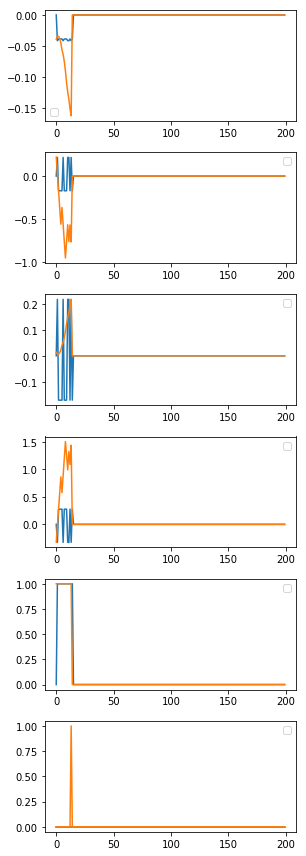

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt 

### Plot the curves of predicted states ### 
### Run one episodes to compare predictions and ground truth ###
s = env.reset()
d = False 
pState = np.zeros((200, 6))
tState = np.zeros((200, 6))
i = 0 
while (not d):
    action = select_action(s)
    nS, r, d, _ = env.step(action)
    tState[i,0] = nS[0]
    tState[i,1] = nS[1]
    tState[i,2] = nS[2]
    tState[i,3] = nS[3]
    tState[i,4] = r 
    tState[i,5] = d*1 
    i+=1

    next_state_p, reward, done = stepModel(s, action)
    state = next_state_p.data.numpy()
    state = state[0]
    reward = reward.data.numpy()[0][0]
    done = done.data.numpy()[0][0]
    done = (done > 0.1)
    
    pState[i,0] = state[0]
    pState[i,1] = state[1]
    pState[i,2] = state[2]
    pState[i,3] = state[3]
    pState[i,4] = reward 
    pState[i,5] = done*1 

plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    predicted = plt.plot(pState[:,i], label='Predicted value')
    plt.subplot(6,2,2*i+1)
    true = plt.plot(tState[:,i], label='True value')
    plt.legend([predicted, true], ['Predicted value', 'True value'])
plt.tight_layout()

In [22]:
print(tState)

[[-0.03706819  0.21245585 -0.03326975 -0.28695186  1.          0.        ]
 [-0.03281908  0.01782377 -0.03900879 -0.00494481  1.          0.        ]
 [-0.0324626   0.21348282 -0.03910769 -0.30967579  1.          0.        ]
 ...
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]
